In [202]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions
import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from statsmodels.tsa.stattools import acf, pacf

# Set up the Data

In [2]:
df = pd.read_csv('../data/clean_train.csv')

In [3]:
#some datetime manipulations
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)

In [4]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

Text(0.5, 1.0, 'Number of Rides over the Year')

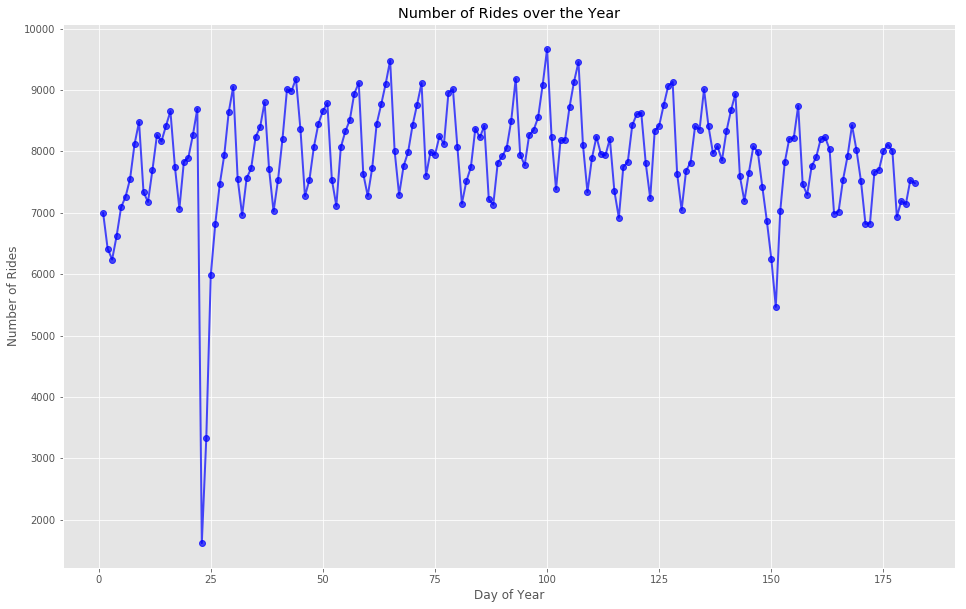

In [205]:
#plotting number of rides over the course of January to June

plt.plot(df.groupby('dayofyear').count()['id'], 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Year')

In [6]:
count =  df.groupby('dayofyear').count()['id']
ts = pd.DataFrame(({'day': count.index, 'count': count.values})).set_index('day')

# Time Series Data Exploration

In [7]:
#view the time series of number of rides per day
ts.head()

,count
day,
1,6993
2,6415
3,6238
4,6620
5,7088


In [8]:
#viewing the lagged time series, the first value becomes NaN
#the dataframe is shifted back one day
#the "tail" loses one last ts value from this lag

ts_lagged = ts.shift()
ts_lagged.head()

,count
day,
1,NaN
2,6993.0
3,6415.0
4,6238.0
5,6620.0


In [9]:
#view the difference between the ts and the lagged ts.

ts.diff().head()

,count
day,
1,NaN
2,-578.0
3,-177.0
4,382.0
5,468.0


Text(0.5, 1.0, 'Number of Rides over the Year')

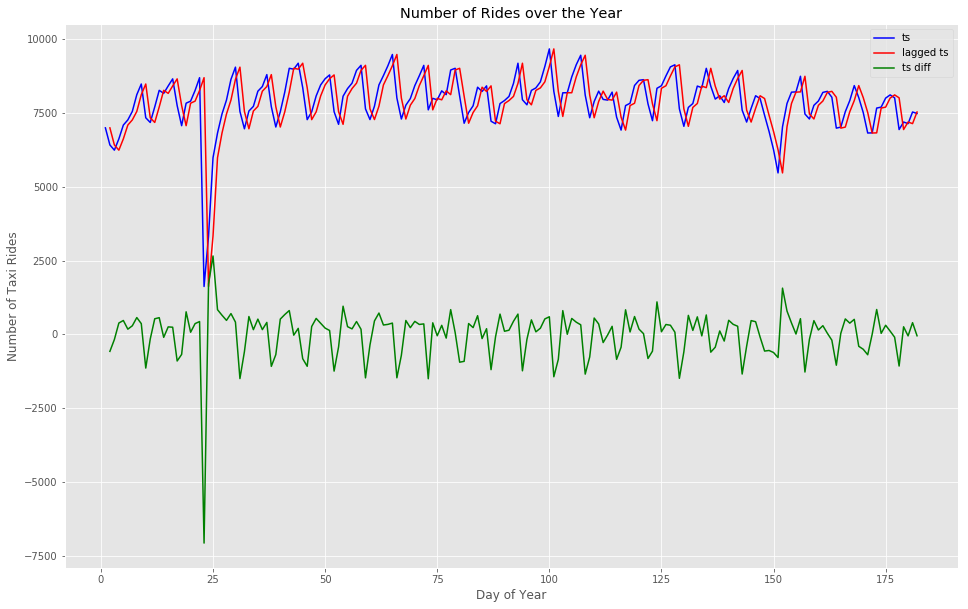

In [206]:
#view the three time series data on one plot

plt1 =  plt.plot(ts, color = 'blue', label = 'ts')
plt2 = plt.plot(ts_lagged, color = 'red', label = 'lagged ts')
plt3 = plt.plot(ts - ts_lagged, color = 'green', label = 'ts diff')
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Number of Taxi Rides')
plt.title('Number of Rides over the Year')

**Moving Window Functions**

In [11]:
#rolling window by 20 days

r = ts.rolling(window = 20)
r

Rolling [window=20,center=False,axis=0]

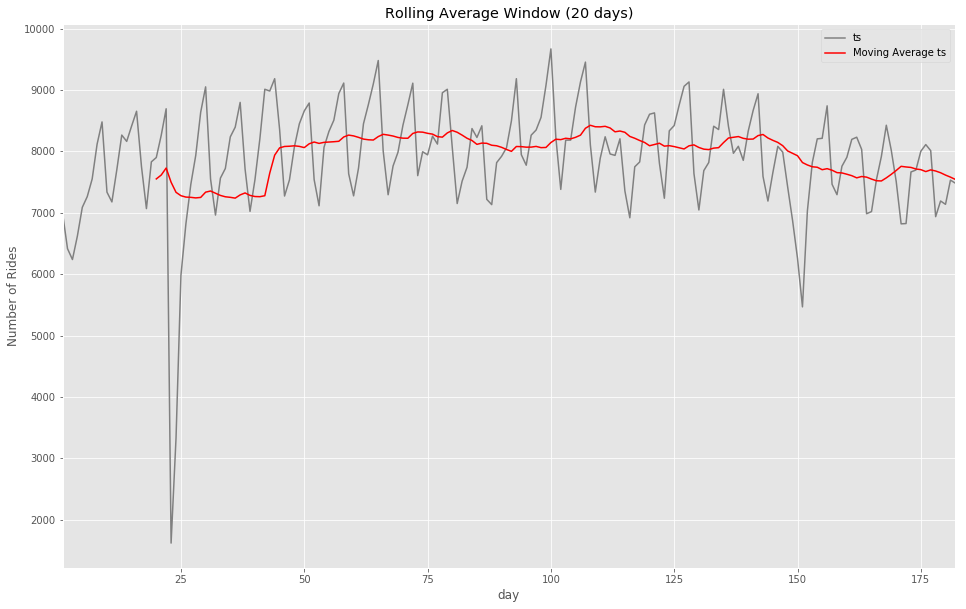

In [207]:
#looking at the moving average
#first 20 observations are nonexistent, since we took those values
#to calculate the moving average window

ts['count'].plot(color = 'gray', label = 'ts')
r.mean()['count'].plot(color = 'red', label = 'Moving Average ts')
plt.ylabel('Number of Rides')
plt.title('Rolling Average Window (20 days)')
plt.legend()

Bigger the moving window, the "smoother" the values get (since the averages will be pooled from a bigger window.)

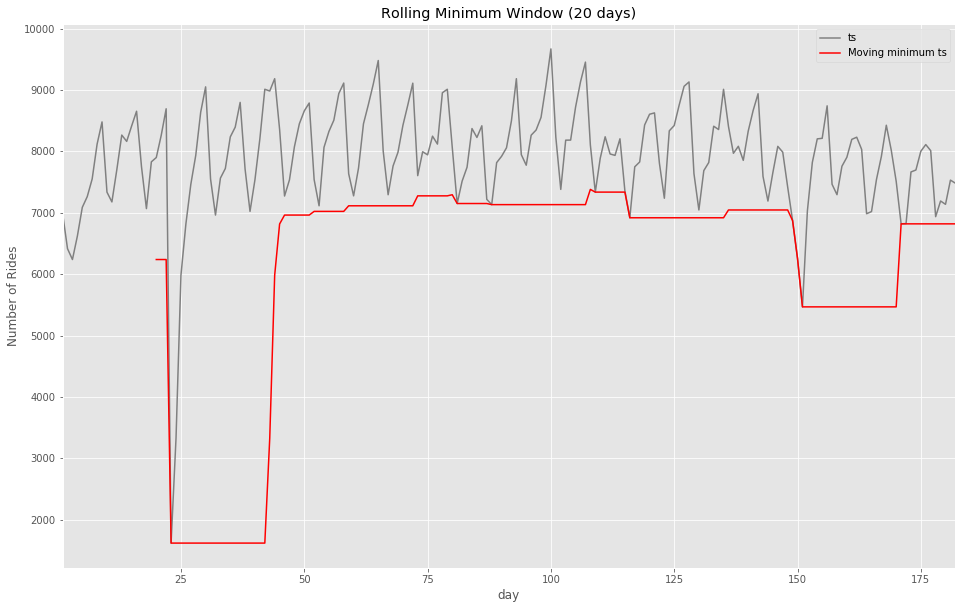

In [208]:
#can use other aggregate functions such as 
#r.agg, r.apply, r.count, r.max, r.median, 
#r.name, r.quantile, r.kurt,r.aggregate, 
#r.std, r.skew, r.sum, r.var 

#can also use custom functions as well.

r.aggregate, r.std, r.skew, r.sum, r.var
ts['count'].plot(color = 'gray', label = 'ts')
r.min()['count'].plot(color = 'red', label = 'Moving minimum ts')
plt.ylabel('Number of Rides')
plt.title('Rolling Minimum Window (20 days)')
plt.legend()

**Brief Expanding window example**

Although we are unlikely to want to use an expanding window since it really only concerns long term trends (and is used more in financial data)

In [14]:
#set minimum window to 1 first
ts.expanding(min_periods = 1).mean()[1:5]

,count
day,
2,6704.000000
3,6548.666667
4,6566.500000
5,6670.800000


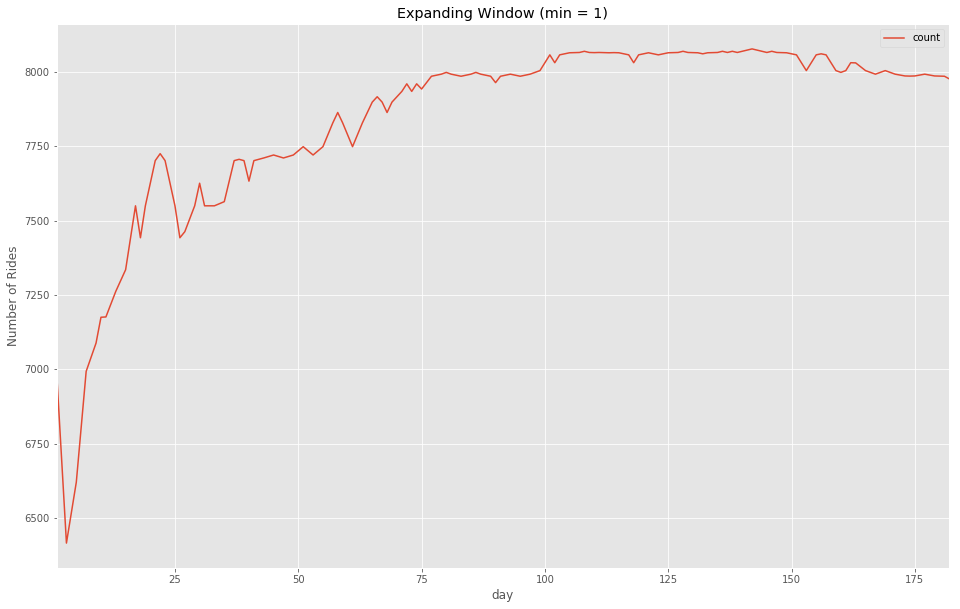

In [209]:
#plotting the expanding window with median values
#cumulative summation of the previous time series values

ts.expanding(min_periods = 1).median().plot(label = 'Expanding Window')
plt.ylabel('Number of Rides')
plt.title('Expanding Window (min = 1)')
plt.legend()

Although it does show a "long term" trend of the number of rides plateauing at around 800 per day, it seems unlikely that we view this as a accurate prediction for ride demand per day. 

**Exponentially weight moving average**

Ann exponential moving average is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. Simply, recency matters in this EWMA model, as in the most recent data points matter the point in determining the time series values.

- notice that the EWMA does not lose the initial window of values

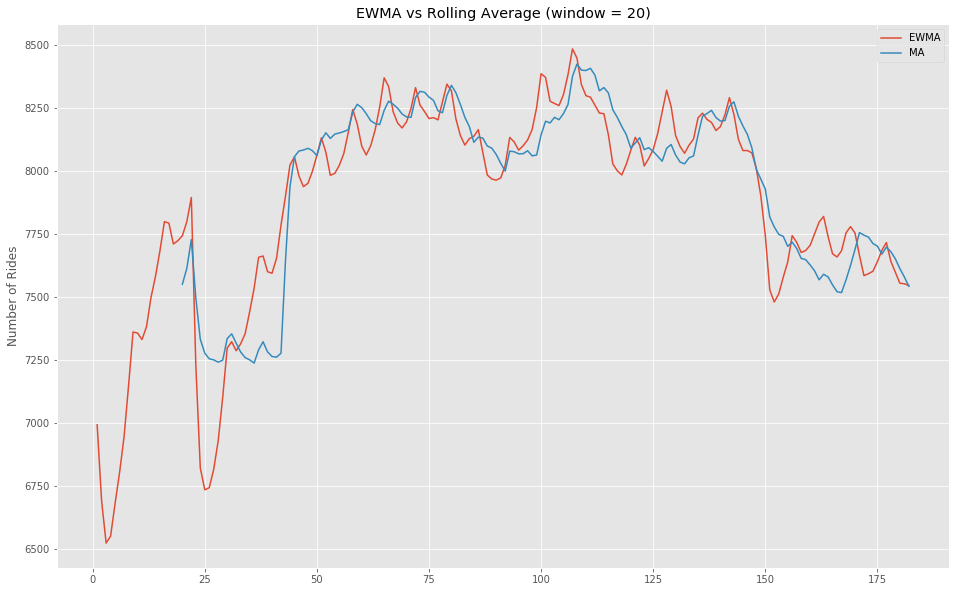

In [210]:
plt.plot(ts.ewm(span = 20,  min_periods = 0, adjust = True).mean(), label = 'EWMA')
plt.plot(ts.rolling(window = 20).mean(), label = 'MA')
plt.ylabel('Number of Rides')
plt.title('EWMA vs Rolling Average (window = 20)')
plt.legend()

# Time Series data relate to themselves

**auto-correlation function**

- Used to help identify possible structures of time series data
- Gives a sense of how different points in time relate to each other in a way explained by temporal distance

- Autocorrelation, also known as serial correlation, is the correlation of a signal with itself at different points in time. Informally, it is the similarity between observations as a function of the time lag between them.


In [17]:
from statsmodels.tsa import stattools

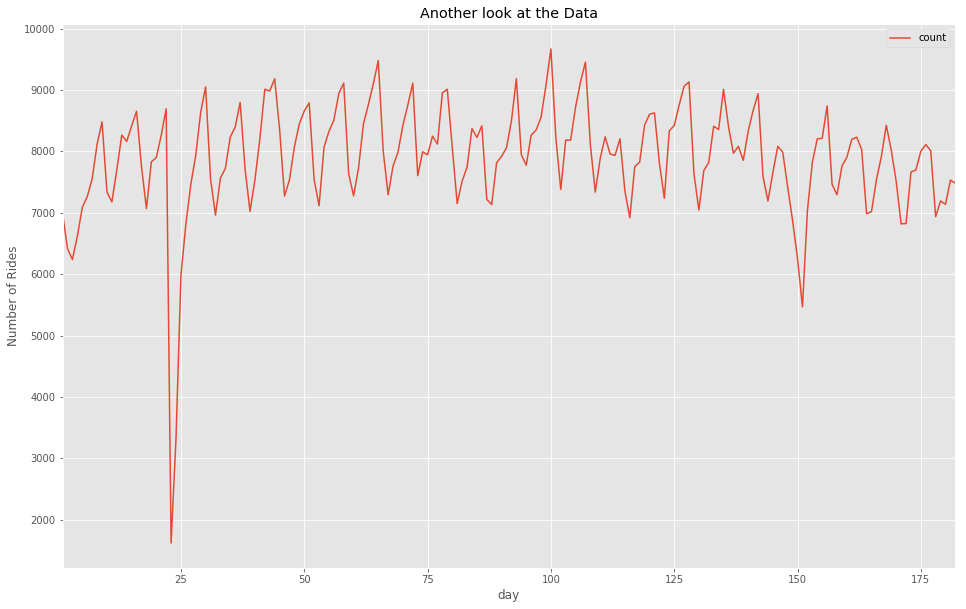

In [211]:
ts.plot()
plt.ylabel('Number of Rides')
plt.title('Another look at the Data')
plt.legend()

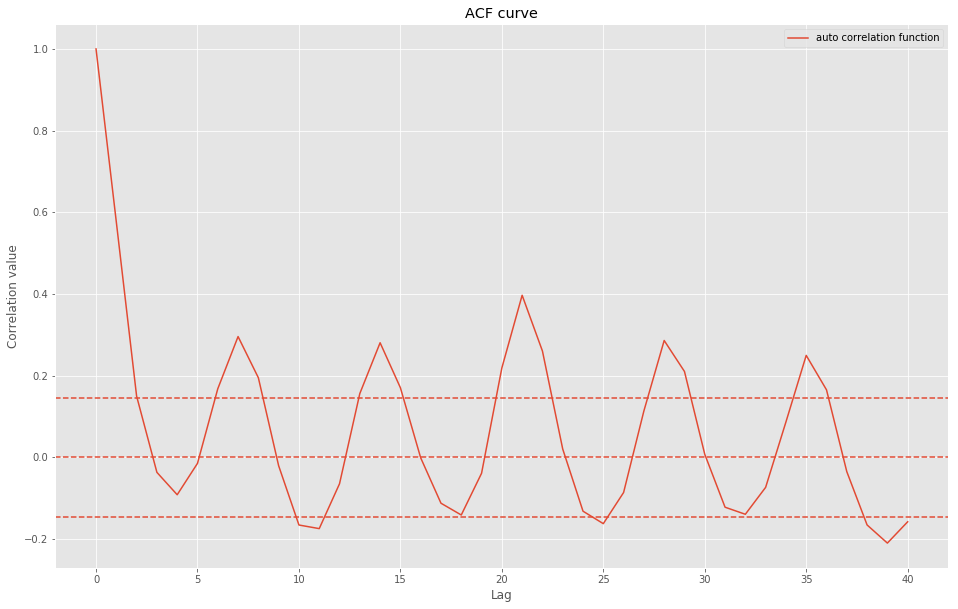

In [212]:
acf_result = stattools.acf(ts)
plt.plot(acf_result, label = 'auto correlation function')
plt.axhline(y=0,linestyle='--')
#creating the 2 std dev dotted lines
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--')
plt.ylabel('Correlation value')
plt.xlabel('Lag')
plt.title('ACF curve')
plt.legend()

The auto correlation at delta = 0 should always be 1, since it is how the data point correlate with itself

For every other data point, the acf curve shows the correlation between the data point at that time with the data point that lags one time period behind it.

The ACF also shows us that the correlation values pops up out of the 95% confidence interval every (approx) 3.5 or half weeks. This recurrent structure tells us that we should de-trend the data. (weekly trends?)

This tells us that there is a very apparent trend every 7 days (and every multiple of 7 days, since this is periodic data), since the correlation function follows a very apparent trend. THe Partial Autocorrelation function can make up for this "harmonic" trend in our periodic data by giving us the patial correlation of a time series with its own lagged values, controlling for the values of time series at all shorter lags.

Furthermore, we can use log and difference transformations to see if we can derive more insight from our data by de-trending the data towards stationarity (where the data, mean, and the variance is constant in time).

###### diff_ts = ts - ts.shift()
diff_ts.plot(label = 'ts diff')
diff_ts.dropna(inplace = True)
plt.ylabel('Count')
plt.title('TS Difference Count values')
plt.legend()

Since the data shows trends and seasonality, we need to remove it by detrending the data through logs and differences, moving average, linear regression, etc.

Take the log of the time series, then difference

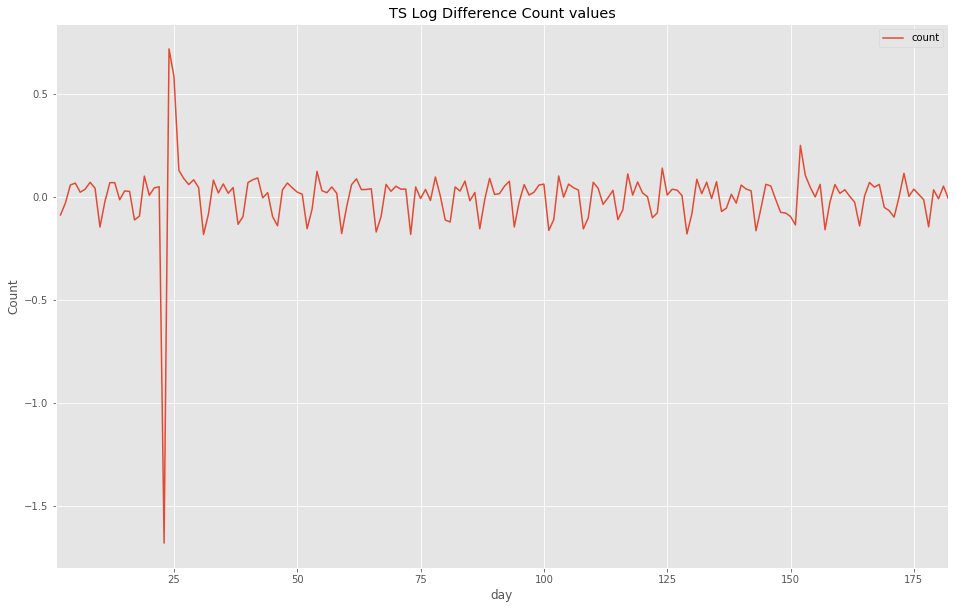

In [213]:
log_ts = np.log(ts)
log_ts_diff = log_ts - log_ts.shift()

log_ts_diff.plot(label = 'Log Difference Count')
plt.ylabel('Count')
plt.title('TS Log Difference Count values')
plt.legend()

look at the ACF for the log difference time series

In [215]:
log_ts_diff.dropna(inplace = True)

Text(0.5, 1.0, 'ACF correlation values for log shifted TS')

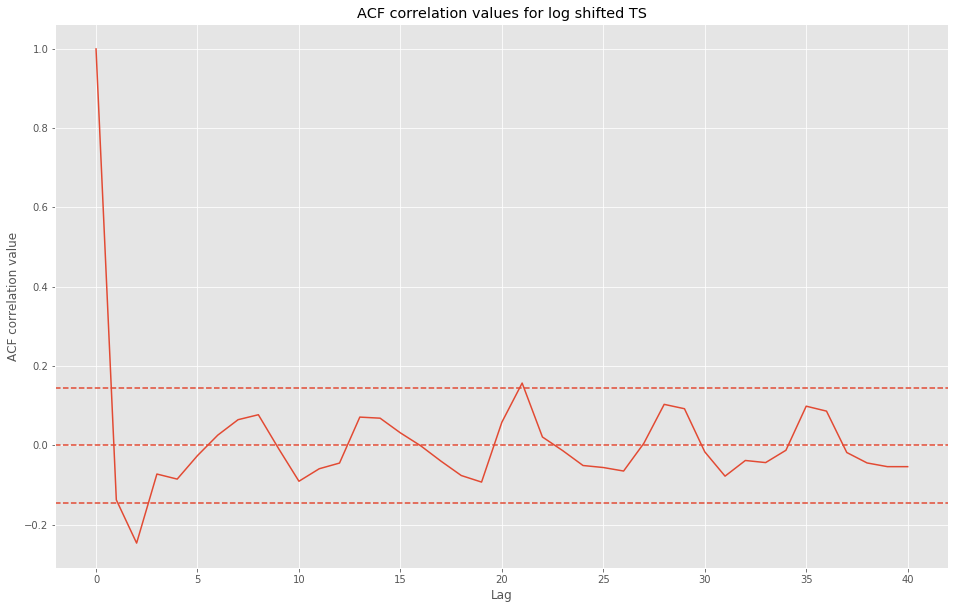

In [216]:
acf_result = stattools.acf(log_ts_diff)
plt.plot(acf_result)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_ts_diff)),linestyle='--')
plt.xlabel('Lag')
plt.ylabel('ACF correlation value')
plt.title('ACF correlation values for log shifted TS')

Judging by the fact that over the course of the entire ACF values, we dont see a huge positive or negative values. We see this because for the most part, the number of taxi trips tended to stay about the same over the course of the year. We didn't see a huge drop (except for on January 23rd) or a huge increase in number of taxis taken per day. 

The internal structure of the count of taxis taken per day stays relatively the same over the year.

Stationary data would have a constant mean, varaiance and ACF. In other words the value, predictability, and struture is not drifting over time.

**Removing Seasonality**

- Simplest method: average the de-trended values for a specific season
- More Common method: use the 'loess' method (locally weighted scatterplot smoothing)

&nbsp; &nbsp; 1) Window of specified width is placed over the data <br>
&nbsp; &nbsp; 2) A weighted regression line or curve is fitted to the data, with points closest to the center of curve having greatest weight <br>
&nbsp; &nbsp; 3) Weighting is reduced on points farthest from regression line and calculation is rerun several times <br>
&nbsp; &nbsp; 4) This yields one point on the loess curve <br>

- Helps reduce the impact of outlier points, but is computationally taxing.


Checking for stationarity below

In [68]:
print("""
The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

Rejecting that there is a unit root -> time series is stationary.
""")


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

Rejecting that there is a unit root -> time series is stationary.



In [217]:
from statsmodels.tsa.stattools import adfuller

useful_values_raw = adfuller(log_ts_diff['count'], autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

,Value,Label
0,-9.262704e+00,Test Statistic
1,9.325540e-14,p-value
2,5.000000e+00,#Lags Used
3,1.750000e+02,Number of Observations Used
4,-4.011455e+00,Critical value for 1%
5,-3.435882e+00,Critical value for 5%
6,-3.141957e+00,Critical value for 10%


Since the pvalue is extremely close to 0, we can reject the null hypothesis and assume that the log difference transformation of the time series has detrended the data significantly enough that it can be considered as stationary.

  # Forecasting
  
  Since we've confirmed that our transformed data can now be considered to be stationary, we can move on to forecasting
  
  **AR + MA processes**
  
  - use PACF for AR model diagnostics
  - use ACF for MA model diagnostics

In [218]:
lag_acf = acf(log_ts_diff.values, nlags = 20)
lag_pacf = pacf(log_ts_diff.values, nlags = 20)

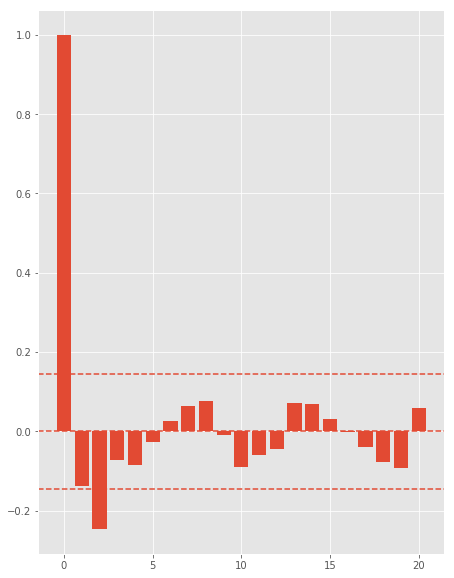

In [219]:
plt.subplot(121) 
plt.bar(x = range(len(lag_acf)), height = lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_ts_diff)),linestyle='--')

The ACF shows that we most likely got rid of the seasonality fairly well, since we only have 1 correlation value outside of the confidence interval throughout the data set

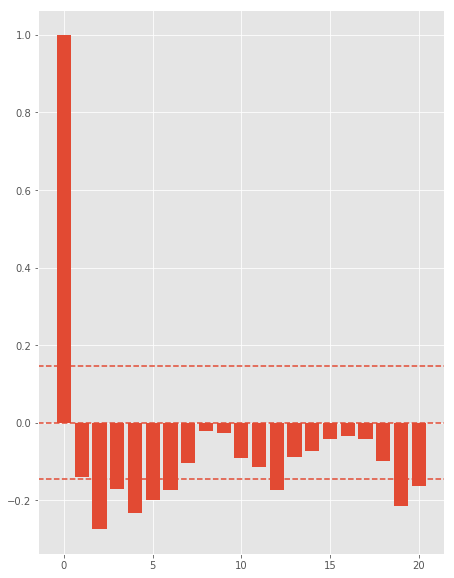

In [220]:
plt.subplot(121) 
plt.bar(x = range(len(lag_pacf)), height = lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_ts_diff)),linestyle='--')

The PACF correlation values show us that for the most part, the time series values are negatively self correlated with its preceding values. 

In [73]:
from statsmodels.tsa.arima_model import ARIMA

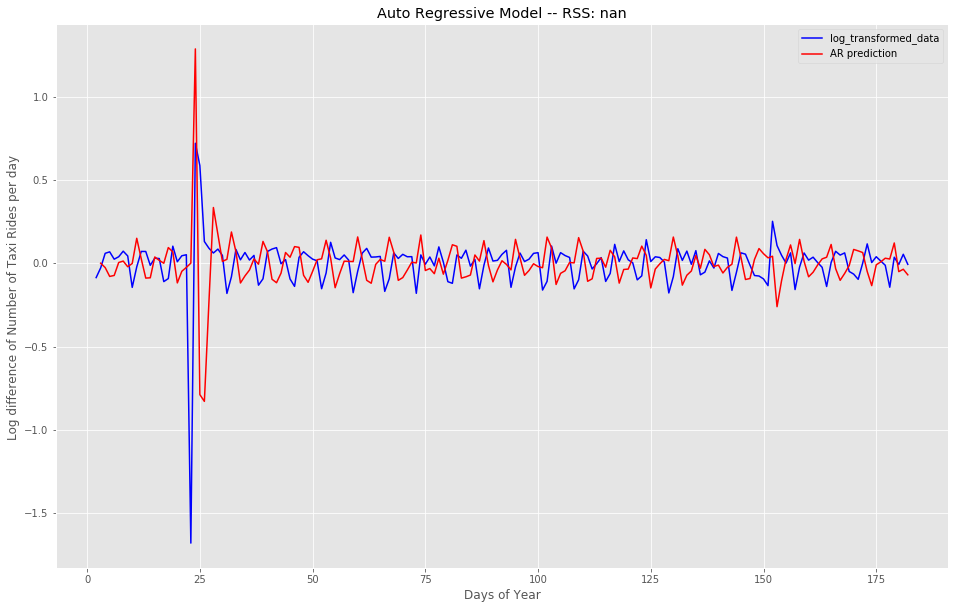

In [229]:
# AR model
# try different values of p
model = ARIMA(log_ts_diff, order=(3, 1, 0))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_AR = model.fit(disp=-1)  
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_AR.fittedvalues, color='red', label= 'AR prediction')
plt.title('Auto Regressive Model -- RSS: %.4f'% sum((results_AR.fittedvalues-log_ts_diff['count'])**2))

plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()

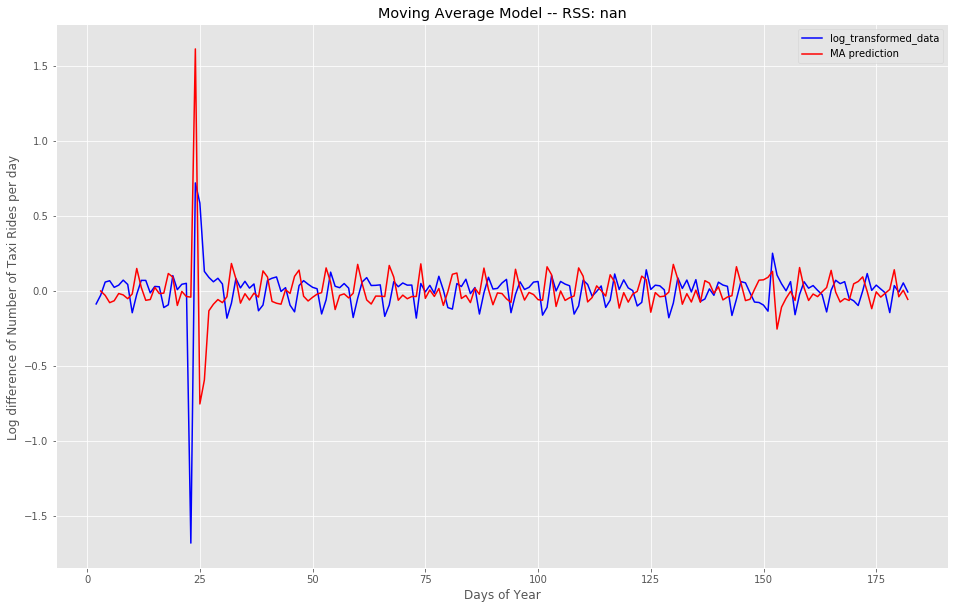

In [222]:
# MA model
# try different values of p
model = ARIMA(log_ts_diff, order=(0, 1, 1))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_MA = model.fit(disp=-1)  
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_MA.fittedvalues, color='red', label= 'MA prediction')
plt.title('Moving Average Model -- RSS: %.4f'% sum((results_MA.fittedvalues-log_ts_diff['count'])**2))

plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()

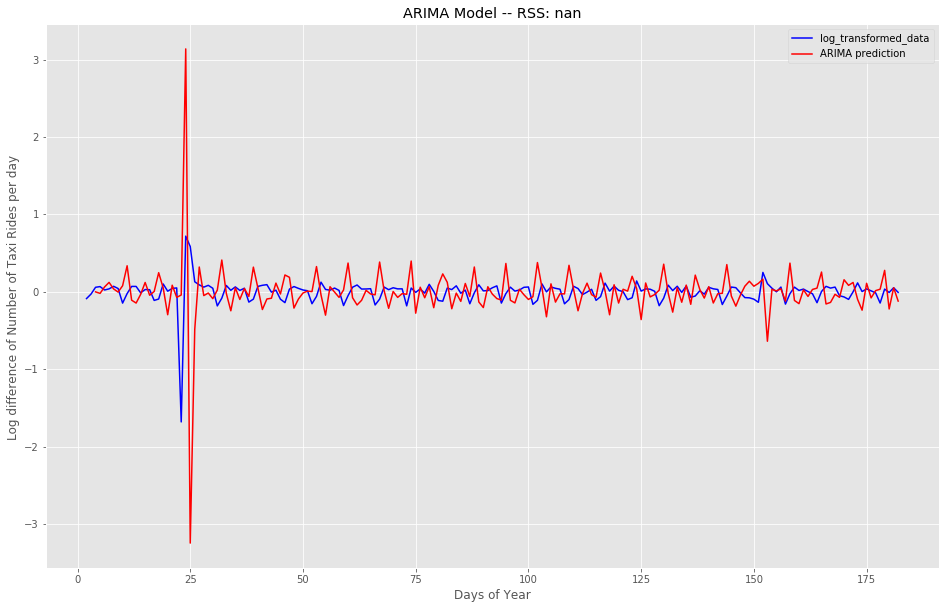

In [223]:
# ARIMA model
# try different values of p
model = ARIMA(log_ts_diff, order=(1,2,3))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_ARIMA.fittedvalues, color='red', label= 'ARIMA prediction')
plt.title('ARIMA Model -- RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_ts_diff['count'])**2))

plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()

We can see that RSS values for both AR and MA processes were most likely so low that they were printed as NaN values. This is because at the scale that both the time series and that AR & MA fitted values occur between 0 and 1. Ultimately, the differences of those two values woudl be a negligebly small demical, which squaring will only make smaller. The sume of such small decimals are probably resulting in a NaN value for the RSS> 

Counterintuitively, when applying an ARIMA process, the RSS value shot up to 3.57. However, this may be because the ARIMA model successfully overlooked the outlier of January 23rd, where the number of taxi trips dropped down significantly. 

# Transforming ARIMA predictions back into Number of Rides

Get fittedvalues for each AR, MA, and ARIMA model

In [230]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

Get the cumsum() for each proceeding value (since we took the shifted difference)

In [231]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum() 
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum() 
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() 

Add the original log value of the time series to the first index of the new predictions series. (will account for the starting place of the predictions since we lost that information during the difference transformation)

In [244]:
predictions_AR_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)

predictions_MA_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)

predictions_ARIMA_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

Raise $e$ by the new values, converting from natural log transformation

In [245]:
predictions_AR = np.exp(predictions_AR_log)
predictions_MA = np.exp(predictions_MA_log)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Plot the predictions

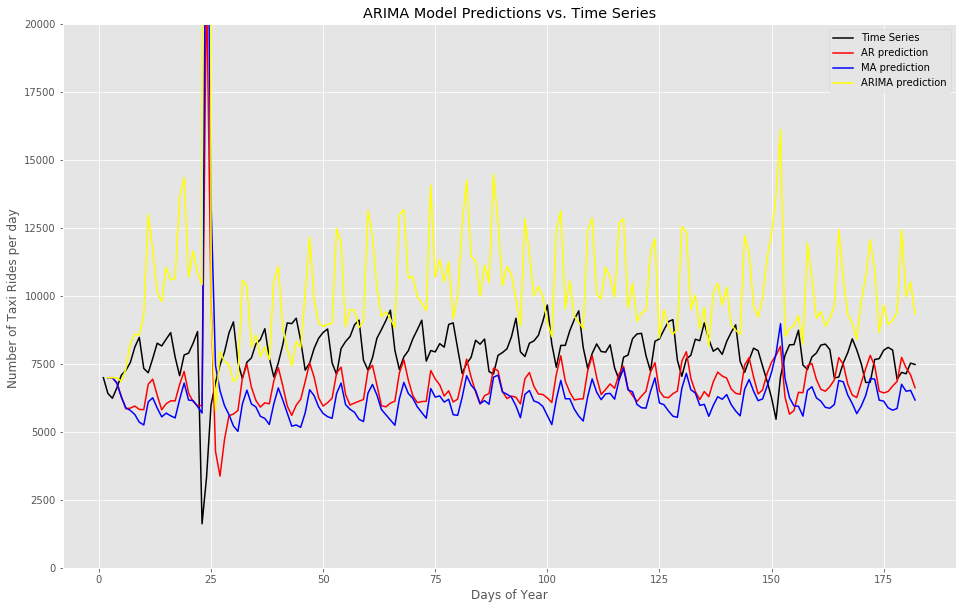

In [246]:
plt.plot(ts, color = 'black', label = 'Time Series')
plt.plot(predictions_AR, color =  'red', label = 'AR prediction')
plt.plot(predictions_MA, color = 'blue', label = 'MA prediction')
plt.plot(predictions_ARIMA, color =  'yellow', label = 'ARIMA prediction')
plt.ylim(0, 20000)  
plt.xlabel('Days of Year')
plt.ylabel('Number of Taxi Rides per day ')
plt.title('ARIMA Model Predictions vs. Time Series')
plt.legend()

We can see that all three predictions do not account for the significant dip in taxi rides of January 23rd as much as the real time series data. We can also see that both AR and MA processes slightly undershoot the number of taxi rides per day, while the ARIMA process over estimates the number of taxi rides per day by a large margin. 

The biggest error comes from the rebounding of all three models that appear right after January 23rd (the day with the significant drop in taxi rides) The models overcompensate and overestimate the next day by a large margin. 

It seesm that for our model, the AR process most accurately captures the trend and is the closest to the actual values of the time series.